<a href="https://colab.research.google.com/github/ArtemkaDS/final_project/blob/main/Fomkin_bunk_churners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn import metrics


# I Анализ и подготовка данных

Загружаем датасет

In [ ]:
bc = pd.read_csv(r'https://raw.githubusercontent.com/ArtemkaDS/final_project/main/Bank_churners.csv')


Отображаем данные

In [ ]:
bc.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Проанализируем описательную статистику на наличие выбросов.

In [ ]:
bc.describe()


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


Выбросов не обнаружено. Далее исследуем на наличие пропусков

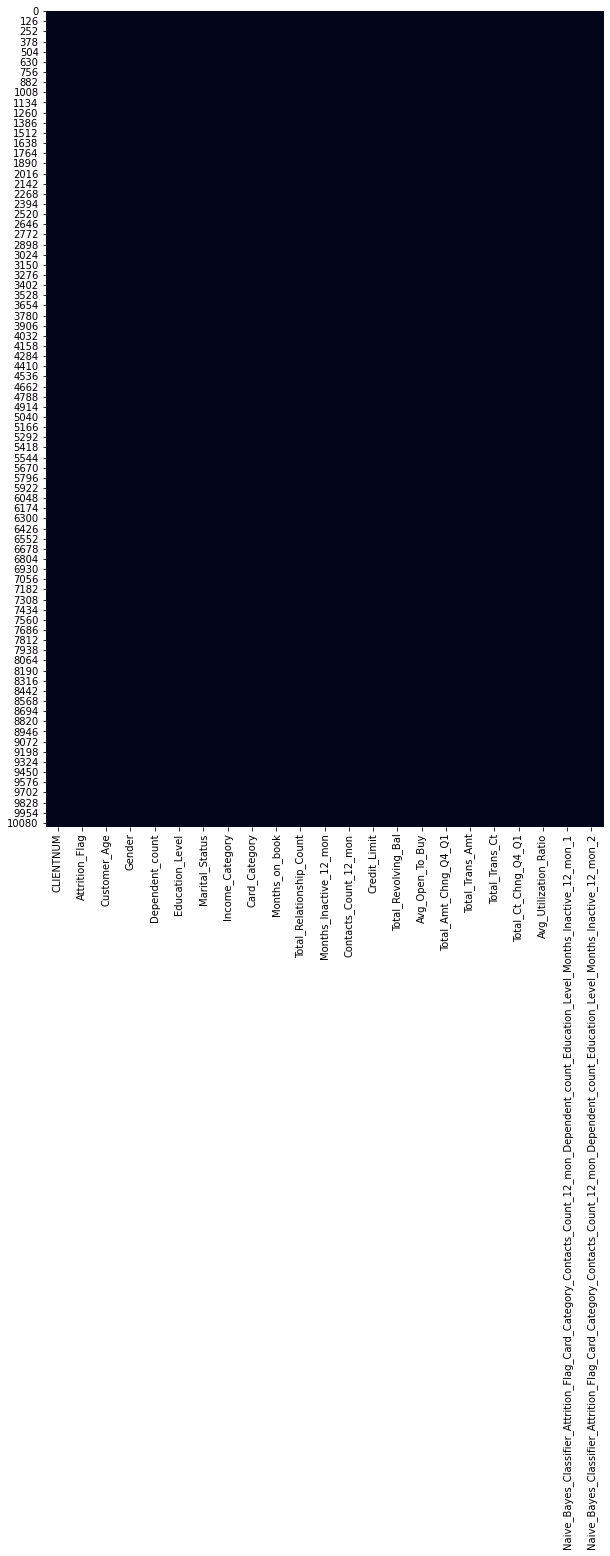

In [ ]:
figure(figsize = (10, 15))
sns.heatmap(bc.isnull(), cbar=False)
plt.show()

Пропусков в данных также не обнаружено. Исследуем целевой параметр

In [ ]:
bc.Income_Category.value_counts()


Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

В выборке находим класс с неизвестными данными "Unknown". Выбрасываем его

In [ ]:
bc = bc[bc.Income_Category != 'Unknown']


backup

In [ ]:
bc1 = bc.copy()


С помощью метода get_dummies из библиотеки pandas добавляем в датасет расширенную матрицу для обучения модели (ставим двоичные флаги по каждому клиенту)

In [ ]:
bc = pd.get_dummies(bc, prefix=['Education_Level', 'Marital_Status', 'Gender',
                                'Card_Category', 'Attrition_Flag'],
                    columns=['Education_Level', 'Marital_Status', 'Gender',
                             'Card_Category', 'Attrition_Flag'])


Смотрим на получившийся дополненный датасет. 

In [ ]:
bc.head()


,CLIENTNUM,Customer_Age,Dependent_count,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Gender_F,Gender_M,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Attrition_Flag_Attrited Customer,Attrition_Flag_Existing Customer
0,768805383,45,3,$60K - $80K,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1
1,818770008,49,5,Less than $40K,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1
2,713982108,51,3,$80K - $120K,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1
3,769911858,40,4,Less than $40K,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1
4,709106358,40,3,$60K - $80K,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1


Выбрасываем нерелевантные параметры, которые никак не повлияют на результат предсказания

In [ ]:
bc = bc.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                          'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                          'Education_Level_Unknown', 'Marital_Status_Unknown'], axis=1)


Смотрим актуальные параметры для обучения модели

In [ ]:
bc.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9015 entries, 0 to 10126
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Customer_Age                      9015 non-null   int64  
 1   Dependent_count                   9015 non-null   int64  
 2   Income_Category                   9015 non-null   object 
 3   Months_on_book                    9015 non-null   int64  
 4   Total_Relationship_Count          9015 non-null   int64  
 5   Months_Inactive_12_mon            9015 non-null   int64  
 6   Contacts_Count_12_mon             9015 non-null   int64  
 7   Credit_Limit                      9015 non-null   float64
 8   Total_Revolving_Bal               9015 non-null   int64  
 9   Avg_Open_To_Buy                   9015 non-null   float64
 10  Total_Amt_Chng_Q4_Q1              9015 non-null   float64
 11  Total_Trans_Amt                   9015 non-null   int64  
 12  Total

Посмотрим на корреляции в датасете на тепловой карте

Text(0.5, 1.0, 'Корреляция данных')

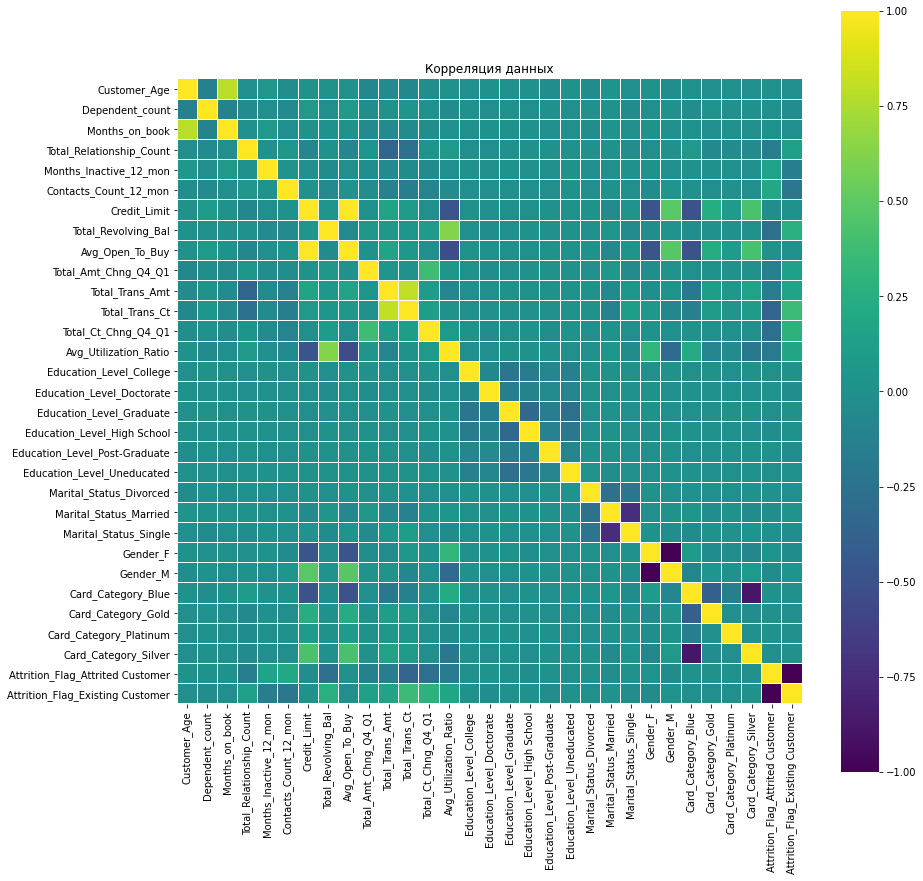

In [ ]:
plt.subplots(figsize=(14,14))
sns.heatmap(bc.corr(), square=True, cmap='viridis',linecolor="white", linewidths=0.005)
plt.title('Корреляция данных')


Наблюдаются очевидно логичные корреляции между **возрастом клиента (customer age)** и сроком его **присутствия в "журналах" в месяцах (months on book)** *(чем старше клиент, тем больше вероятность его раннего появления в базе)*, а также между **общим количеством транзакций** и **общим количеством категорий по этим транзакциям**. Считаю данные корреляции некритичными. 
Также наблюдается почти 100%-ая корреляция показателя **кредитный лимит (credit limit)** и показателем **open to buy**

Выбрасываем показатель **кредитный лимит**

In [ ]:
bc = bc.drop(['Credit_Limit'], axis=1)


Выделяем целевую переменную и создаем обучающую выборку

In [ ]:
X = bc.drop(['Income_Category'], axis=1)
y = bc.Income_Category


Визуально оценим распределение признаков по нашей выборке

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4f7f7c940>,
      dtype=object)

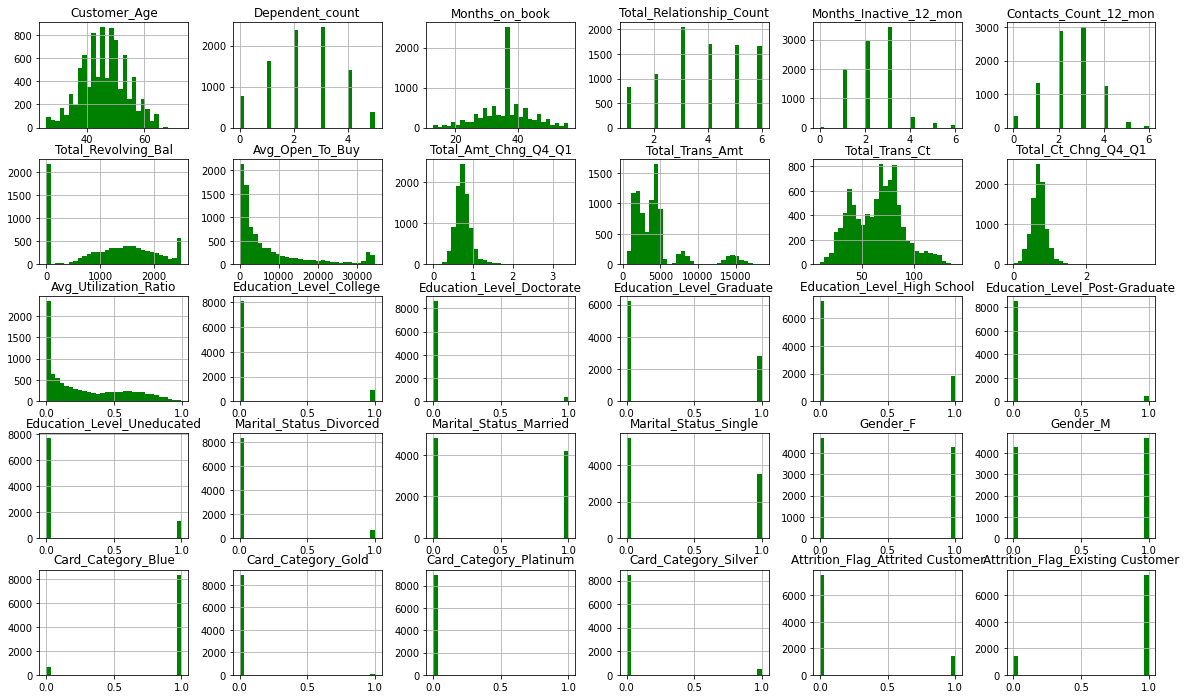

In [ ]:
X.hist(figsize=(20, 12), layout=(5,6), bins=30, facecolor='g')
plt.show()


На основании визуального анализа выборки видим, что значения возраста *(Customer Age)* сосредоточены в основной своей массе от 40 до 50. Пол *(Gender)* и семейное положение *(Marital Status)* распределены примерно поровну, существующих клиентов *(Existing Customer)* больше, чем привлеченных *(Attrited Customer)*

Выделим для теста 30% и разделим выборку на обучающую и тестовую в соотношении 70 / 30.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Посмотрим на наши классы на предмет необходимости балансировки

In [ ]:
inc_values = bc.Income_Category.value_counts()
df_inc_values = pd.DataFrame({'Count': inc_values})
df_inc_values.index.names = ['Category']
df_inc_values


,Count
Category,
Less than $40K,3561
$40K - $60K,1790
$80K - $120K,1535
$60K - $80K,1402
$120K +,727


Для наглядности отразим их на графике

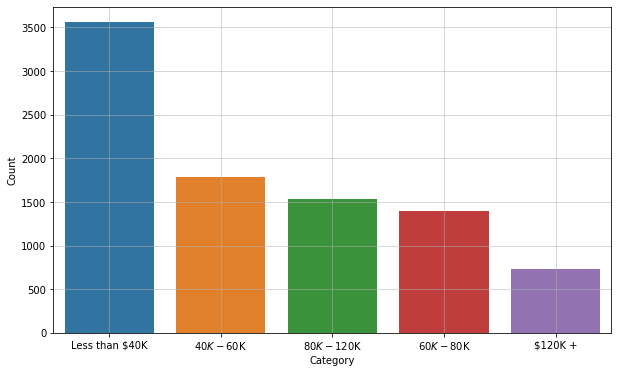

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df_inc_values.index, y='Count', data=df_inc_values)
plt.grid(which='major',
         linewidth=0.5)
plt.show()


Видим, что данные классов немного не сбалансированы. Применим оверсемплинг для баланиросвки данных. Воспользуемся *SMOTE* алогритмом из библиотеки *imblearn* и сгенерируем данные для миноритарных классов 

In [ ]:
sm = SMOTE(random_state = 42)
X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

# II Обучение модели

## 1. Random Forest

Будем решать задачу классификации с помощью алогритма *Random Forest*

In [ ]:
clf = RandomForestClassifier()


Используем *GridSearchCV* для подбора параметров нашей модели. Ограничим число деревьев в лесу от 400 до 410, максимальную глубину ограничим от 8 до 12. Для кросс-валидации установим 3 фолда.

In [ ]:
grid_clf_RF = GridSearchCV(clf,
                        {'n_estimators': range(400, 411),
                        'max_depth': range(8, 13)},
                        cv=3)
grid_clf_RF.fit(X_train_oversampled, y_train_oversampled)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Находим лучшие параметры для нашего метода

In [ ]:
grid_clf_RF.best_params_


{'max_depth': 12, 'n_estimators': 408}

Сохраняем параметры

In [ ]:
best_clf = grid_clf_RF.best_estimator_


Смотрим score при лучших условиях

In [ ]:
best_clf.score(X_test, y_test)


0.577818853974122

Score на тестовой выборке показал 58%. 

In [ ]:
y_pred = best_clf.predict(X_test)


In [ ]:
print(metrics.classification_report(y_test, y_pred))


                precision    recall  f1-score   support

       $120K +       0.36      0.27      0.31       211
   $40K - $60K       0.47      0.08      0.13       536
   $60K - $80K       0.38      0.62      0.47       416
  $80K - $120K       0.42      0.44      0.43       443
Less than $40K       0.77      0.92      0.84      1099

      accuracy                           0.58      2705
     macro avg       0.48      0.47      0.44      2705
  weighted avg       0.56      0.58      0.53      2705



Из отчета об оценке видим, что результаты точности *(precision)*, полноты *(recall)* и f-меры *(f-score)* выше всего у класса **"Меньше 40 т долл."**. Также показатель точности относительно средний для всех классов. Общий показатель точности 58%. Из-за значения *support*
Недостаточно хороший результат, попробуем ниже другие методы, но сначала проанализируем влияние параметров на предсказание

In [ ]:
features = best_clf.feature_importances_


In [ ]:
feature_importances = pd.DataFrame({'features': list(X), 'feature_importances': features })
feature_importances.sort_values('feature_importances', ascending=False, inplace=True)


Проанализируем получившиеся веса на графике

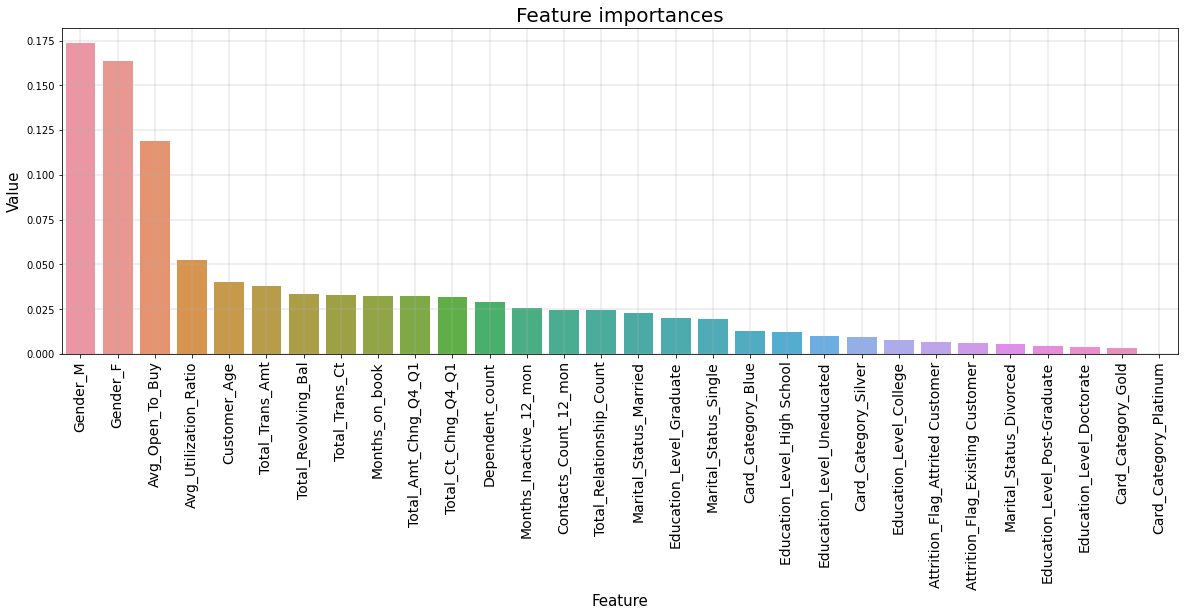

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(x=feature_importances['features'],
            y=feature_importances['feature_importances'],
            data=feature_importances)
plt.grid(linewidth=0.4)
plt.xticks(rotation=90, fontsize=14)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.title('Feature importances', fontsize=20)
plt.show()


Видим, что Random Forest макисмально влияющими на заработок клиентов банка считает пол в большей степени и показатель "Open to buy" немного в меньшей. Также можно отметить, что в гораздо меньшей степени, но согласно предсказанию RF влияют на заработок возраст клиента и количество совершаемых им транзакций за отчетный перирод. Остальные показатели влияют много меньше

## 2. Логистическая регрессия

Попробуем применить другой метод для решения задачи классификации - логистическую регрессию

In [ ]:
logr = LogisticRegression(max_iter=10000)
grid_clf_logr = GridSearchCV(logr,
                        {'penalty': ['l1', 'l2'],
                        'solver': ['sag', 'saga', 'lbfgs']},
                        cv=3)
grid_clf_logr.fit(X_train_oversampled, y_train_oversampled)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternati

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['sag', 'saga', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Сохраним лучшие параметры

In [ ]:
grid_clf_logr.best_params_

{'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
best_clf_logr = grid_clf_logr.best_estimator_
best_clf_logr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = best_clf_logr.predict(X_test)
y_pred

array(['Less than $40K', '$80K - $120K', 'Less than $40K', ...,
       '$80K - $120K', 'Less than $40K', '$40K - $60K'], dtype=object)

In [ ]:
best_clf_logr.score(X_test, y_test)


0.5153419593345656

Score регрессии демонстрирует результат в 52%. Существенно ниже, чем показал RFR

Смотрим отчет по метрикам

In [ ]:
print(metrics.classification_report(y_test, y_pred))


                precision    recall  f1-score   support

       $120K +       0.29      0.49      0.37       211
   $40K - $60K       0.25      0.15      0.19       536
   $60K - $80K       0.33      0.54      0.41       416
  $80K - $120K       0.38      0.16      0.23       443
Less than $40K       0.78      0.83      0.80      1099

      accuracy                           0.52      2705
     macro avg       0.41      0.43      0.40      2705
  weighted avg       0.50      0.52      0.49      2705



Метрики качества хуже, чем продемонстрировал RandomForest

Проанализируем коэффициенты из результатов предсказания логистической регрессии

In [ ]:
best_clf_logr.coef_[0]


array([ 4.15512100e-03, -4.08290813e-02, -6.88476265e-03, -7.91824023e-02,
       -6.04069923e-02, -6.96601696e-02,  1.41468529e-04,  1.11670218e-04,
       -3.47266952e-02, -4.72023846e-05, -1.91003567e-03, -5.43828573e-02,
       -4.11361943e-04, -3.46855028e-02,  1.74388998e-02, -5.87414963e-02,
       -2.92074428e-02, -2.75451234e-02,  3.45797528e-02, -1.88513106e-02,
        5.42430332e-02, -4.85688379e-02, -2.70700880e-01,  2.17855131e-01,
        9.54999256e-02, -1.61937425e-02,  3.13034248e-03, -1.35282275e-01,
        9.19872002e-03, -6.20444694e-02])

Нормализуем коэффициенты с помощью экспоненты

In [ ]:
coeffs = np.exp(best_clf_logr.coef_[0])


Посмотрим на коэффициенты

In [ ]:
df_coeffs = pd.DataFrame(coeffs,
                        X.columns,
                        columns=['coefficient']).sort_values('coefficient', ascending=False)


In [ ]:
df_coeffs.reset_index(inplace=True)
df_coeffs.rename({'index': 'feature'}, axis=1, inplace=True)
df_coeffs

,feature,coefficient
0,Gender_M,1.243407
1,Card_Category_Blue,1.100209
2,Marital_Status_Married,1.055741
3,Education_Level_Uneducated,1.035185
4,Education_Level_Doctorate,1.017592
5,Attrition_Flag_Attrited Customer,1.009241
6,Customer_Age,1.004164
7,Card_Category_Platinum,1.003135
8,Total_Revolving_Bal,1.000141
9,Avg_Open_To_Buy,1.000112


Оценим на графике

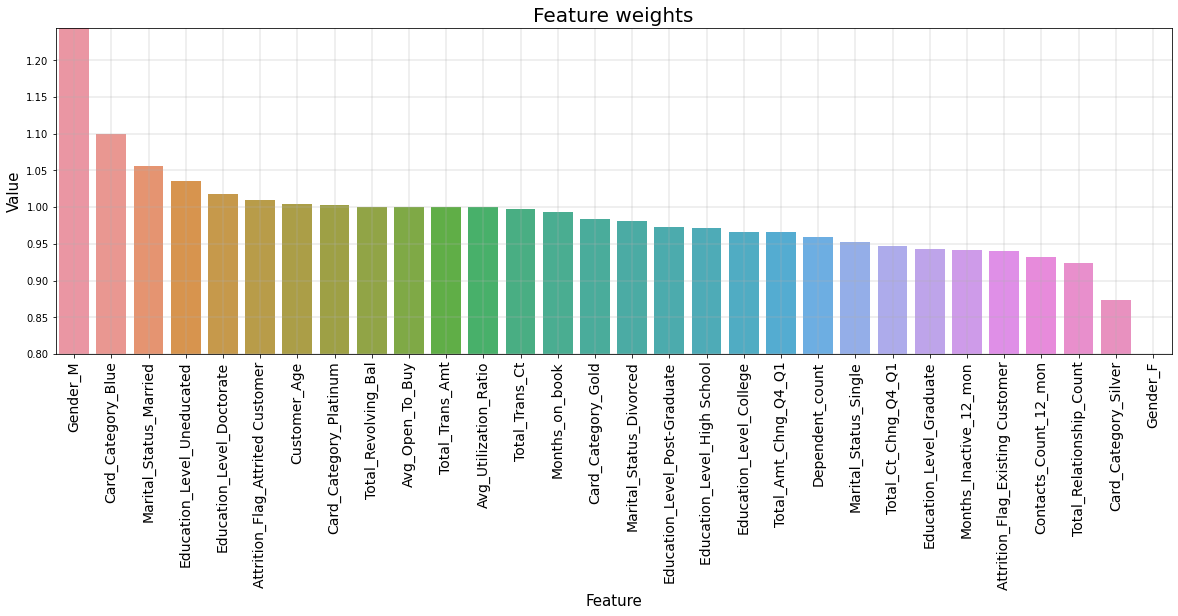

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(x=df_coeffs['feature'],
            y=df_coeffs['coefficient'],
            data=df_coeffs)
plt.grid(linewidth=0.4)
plt.xticks(rotation=90, fontsize=14)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.ylim(0.8, 1.244)
plt.title('Feature weights', fontsize=20)
plt.show()


Видим, что модель работает хуже, чем с Random Forest, однако также четко прослеживается влияение пола на зарплату.

## 3. Random Forest Regressor

Подготовим данные класса *Income Category* для обучения

In [ ]:
bc['Income_Category'].unique()


array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +'], dtype=object)

In [ ]:
bc['Income_Category'] = bc['Income_Category'].replace(['Less than $40K', '$40K - $60K',  '$60K - $80K', '$80K - $120K', '$120K +'],
                                                        list(range(0,5)))


In [ ]:
bc.head()

,Customer_Age,Dependent_count,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Gender_F,Gender_M,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Attrition_Flag_Attrited Customer,Attrition_Flag_Existing Customer
0,45,3,2,39,5,1,3,777,11914.0,1.335,1144,42,1.625,0.061,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1
1,49,5,0,44,6,1,2,864,7392.0,1.541,1291,33,3.714,0.105,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1
2,51,3,3,36,4,1,0,0,3418.0,2.594,1887,20,2.333,0.000,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1
3,40,4,0,34,3,4,1,2517,796.0,1.405,1171,20,2.333,0.760,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1
4,40,3,2,21,5,1,0,0,4716.0,2.175,816,28,2.500,0.000,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1


In [ ]:
X = bc.drop(['Income_Category'], axis=1)
y = bc.Income_Category


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Попробуем применять другой "лесной" метод *Random Forest Regressor* 

In [ ]:
rf_reg = RandomForestRegressor()


Обучим модель на тех же параметрах

In [ ]:
grid_clf_rfr = GridSearchCV(rf_reg,
                        {'n_estimators': range(409, 411),
                        'max_depth': range(8, 10)},
                        cv=3)
grid_clf_rfr.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

Достаем лучшие параметры и анализируем качество

In [ ]:
grid_clf_rfr.best_params_


{'max_depth': 8, 'n_estimators': 409}

In [ ]:
best_clf_rfr = grid_clf_rfr.best_estimator_


In [ ]:
best_clf_rfr.score(X_test, y_test)


0.7266633507490062

Хороший результат в 73%

In [ ]:
y_pred = best_clf_rfr.predict(X_test)


Сразу видим, что регрессор показал более точные результаты

Оценим результаты визуально

In [ ]:
features = best_clf_rfr.feature_importances_


In [ ]:
feature_importances = pd.DataFrame({'features': list(X), 'feature_importances': features })
feature_importances.sort_values('feature_importances', ascending=False, inplace=True)
feature_importances


,features,feature_importances
23,Gender_M,0.402848
22,Gender_F,0.374895
7,Avg_Open_To_Buy,0.103444
0,Customer_Age,0.047354
24,Card_Category_Blue,0.021274
9,Total_Trans_Amt,0.007265
6,Total_Revolving_Bal,0.006984
11,Total_Ct_Chng_Q4_Q1,0.005491
10,Total_Trans_Ct,0.005211
8,Total_Amt_Chng_Q4_Q1,0.005105


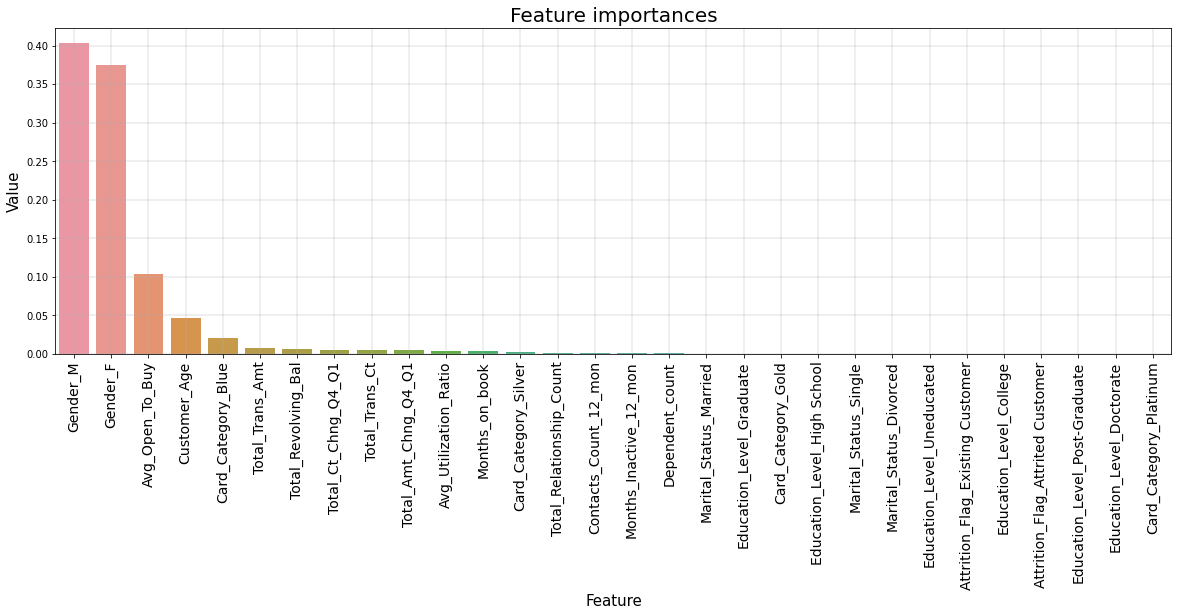

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(x=feature_importances['features'],
            y=feature_importances['feature_importances'],
            data=feature_importances)
plt.grid(linewidth=0.4)
plt.xticks(rotation=90, fontsize=14)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.title('Feature importances', fontsize=20)
plt.show()


Видим, что регрессор продемонстрировал гораздо лучшие результаты, показав тот же вывод, но с гораздо большими весами. Можно сделать предварительный вывод, что пол, кредитный показатель *open to buy* и возраст клиента влияют на предсказание заработанной платы клиента в наибольшей степени. Остальные показатели не заслуживают внимания

Прежде, чем делать окончательные выводы, попробуем обучить модель на ЛР

## 4. Метод опорных векторов

Оценим последний метод - метод опорных векторов

In [ ]:
pipeline = Pipeline(
    [('scalar1', StandardScaler()),
    ('lr_classifier', SVR(kernel='rbf'))]
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scalar1',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr_classifier',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
pipeline.score(X_test, y_test)

0.6881170767831877

Результат лучше, чем у регрессии, однако хуже, чем у *random forest regressor*, поэтмоу применять для предсказания его не будем

# III Анализ и визуализация результатов обучения

Отсортируем и сгруппируем данные 

In [ ]:
bc1['Income_Category'] = bc1['Income_Category'].replace(['Less than $40K', '$120K +'], ['$39.9K and less', 'More than $120K'])


In [ ]:
inc_by_gender = bc1[['Gender', 'Income_Category']]


In [ ]:
inc_by_gender = pd.DataFrame(bc1.groupby('Gender')['Income_Category'].value_counts())


In [ ]:
inc_by_gender.columns = ['Number_of_People']


In [ ]:
inc_by_gender.reset_index(inplace=True)


In [ ]:
inc_by_gender = inc_by_gender.sort_values(['Income_Category'])


In [ ]:
inc_by_gender


,Gender,Income_Category,Number_of_People
0,F,$39.9K and less,3284
6,M,$39.9K and less,277
1,F,$40K - $60K,1014
4,M,$40K - $60K,776
3,M,$60K - $80K,1402
2,M,$80K - $120K,1535
5,M,More than $120K,727


Наглядно посмотрим на графики зависимостей заработанной платы от пола и показателя **open to buy**

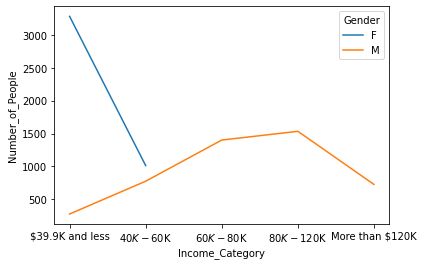

In [ ]:
sns.lineplot(data=inc_by_gender, x='Income_Category', y='Number_of_People', hue='Gender', sort=True)


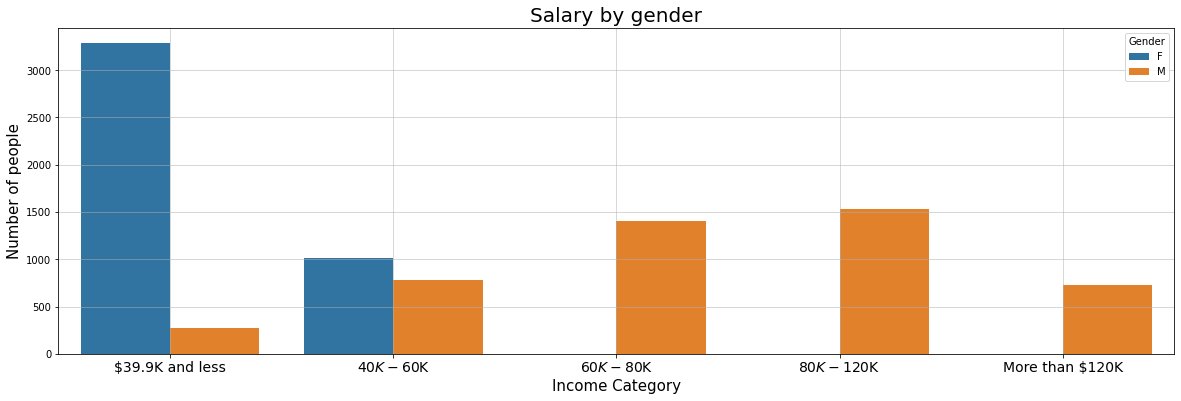

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(x='Income_Category',
            y='Number_of_People',
            hue='Gender',
            data=inc_by_gender)
plt.grid(linewidth=0.5)
plt.xticks(fontsize=14)
plt.xlabel('Income Category', fontsize=15)
plt.ylabel('Number of people', fontsize=15)
plt.title('Salary by gender', fontsize=20)
plt.show()


Проанализируем предсказание по показателю *Open To Buy*

In [ ]:
avg_otb = bc1[['Avg_Open_To_Buy', 'Income_Category']]


In [ ]:
avg_otb = avg_otb.sort_values(['Income_Category'])


In [ ]:
avg_otb.head()


,Avg_Open_To_Buy,Income_Category
4992,394.0,$39.9K and less
5516,1696.0,$39.9K and less
5513,1217.0,$39.9K and less
5512,740.0,$39.9K and less
5510,723.0,$39.9K and less


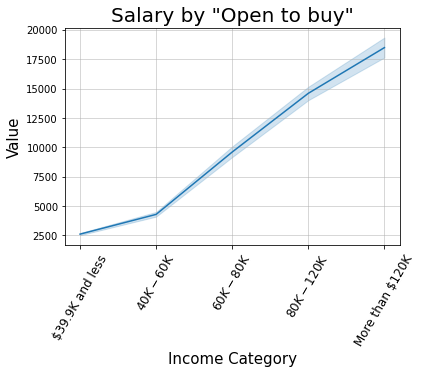

In [ ]:
sns.lineplot(data=avg_otb, x='Income_Category', y='Avg_Open_To_Buy')
plt.grid(linewidth=0.5)
plt.xticks(fontsize=12, rotation=60)
plt.xlabel('Income Category', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.title('Salary by "Open to buy"', fontsize=20)
plt.show()


Также посмотрим зависимость от возраста, которую продемонстрировали 2 из 3 примененных алгоритмов

In [ ]:
bc1.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,$39.9K and less,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,$39.9K and less,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [ ]:
inc_by_age = bc1[['Customer_Age', 'Income_Category']]
inc_by_age


,Customer_Age,Income_Category
0,45,$60K - $80K
1,49,$39.9K and less
2,51,$80K - $120K
3,40,$39.9K and less
4,40,$60K - $80K
...,...,...
10122,50,$40K - $60K
10123,41,$40K - $60K
10124,44,$39.9K and less
10125,30,$40K - $60K


In [ ]:
inc_by_age = inc_by_age.sort_values(['Income_Category'], ascending=False)


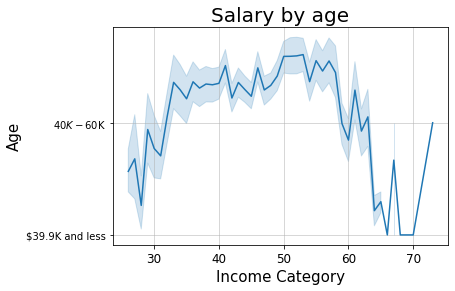

In [ ]:
sns.lineplot(data=inc_by_age, y='Income_Category', x='Customer_Age')
plt.grid(linewidth=0.5)
plt.xticks(fontsize=12)
plt.xlabel('Income Category', fontsize=15)
plt.ylabel('Age', fontsize=15)
plt.title('Salary by age', fontsize=20)
plt.show()


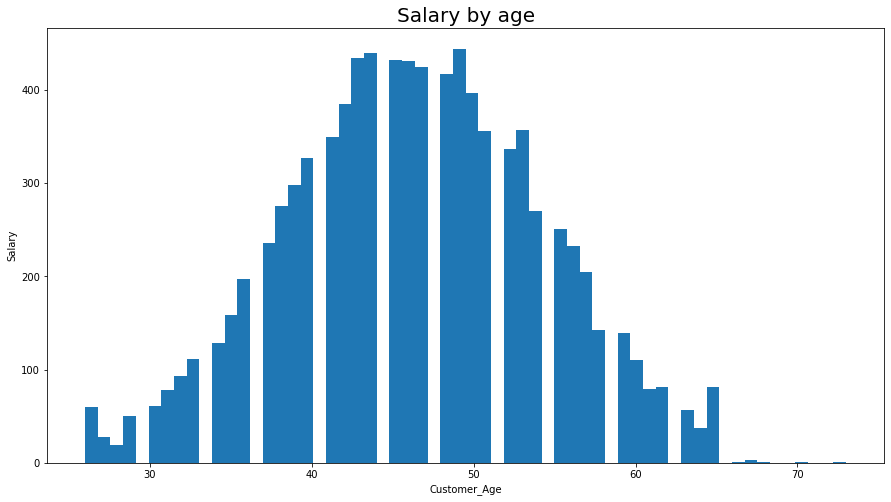

In [ ]:
figure = plt.figure(figsize=(15,8))
plt.hist([inc_by_age['Customer_Age']], bins=60)
plt.xlabel('Customer_Age')
plt.title('Salary by age', fontsize=20)
plt.ylabel('Salary')
plt.show()


# IV Заключение

В ходе анализа была произведена чистка данных, балансировка данных сэта. Датасет был создано проанализирован с помощью 4 методов машинного обучения, решая задачу классификации по заработанной плате.

Из трех методов (Random Forest, Random Forest Regressor, логистической регрессии и метода опроных векторов) лучшие результаты показал Random Forest Regressor.

Из анализа графиков, выведенных на основе результатов обучения модели, можно с уверенностью заключить, что на уровень дохода клиентов банка максимальное значение оказывают пол и показатель avg_open_to_buy, то есть размер кредита, доступного для покупки на данный момент, а также в меньшей степени - возраст. Все остальные данные влияют на уровень заработной платы весьма слабо. 

Проект может быть весьма широко использован аналитиками банка для оценки клиентов. 
Примеры практического применения:
- решение об ориентировании маркетинга на определенную группу населения;
- разработка стратегий подходов/линейки продуктов/персональных предложений для градаций клиентов